Device: cuda
Dataset folders: ['daisy', 'tulip', 'rose', 'sunflower', 'dandelion']
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train: 3453 Val: 864
Epoch 1: Train=0.376, Val=0.549
Epoch 2: Train=0.616, Val=0.685
Epoch 3: Train=0.718, Val=0.763
Epoch 4: Train=0.774, Val=0.806
Epoch 5: Train=0.798, Val=0.825
Epoch 6: Train=0.812, Val=0.830
Epoch 7: Train=0.828, Val=0.846
Epoch 8: Train=0.836, Val=0.848
Epoch 9: Train=0.842, Val=0.850
Epoch 10: Train=0.854, Val=0.859
Epoch 1: Train=0.656, Val=0.833
Epoch 2: Train=0.838, Val=0.855
Epoch 3: Train=0.859, Val=0.869
Epoch 4: Train=0.864, Val=0.866
Epoch 5: Train=0.875, Val=0.882
Epoch 6: Train=0.887, Val=0.881
Epoch 7: Train=0.885, Val=0.884
Epoch 8: Train=0.889, Val=0.881
Epoch 9: Train=0.888, Val=0.885
Epoch 10: Train=0.889, Val=0.888


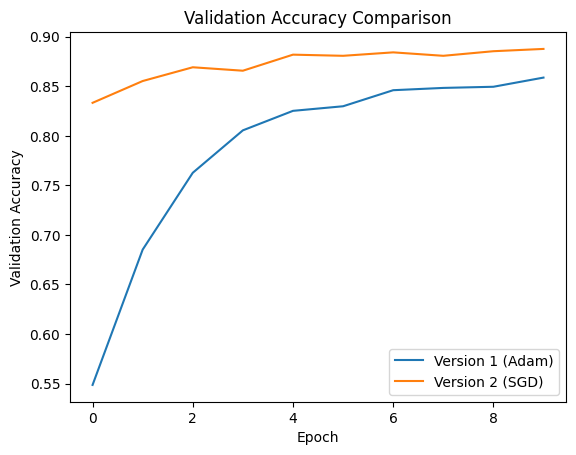

            Version  Best Val Accuracy
0  Version 1 (Adam)           0.858796
1   Version 2 (SGD)           0.887731


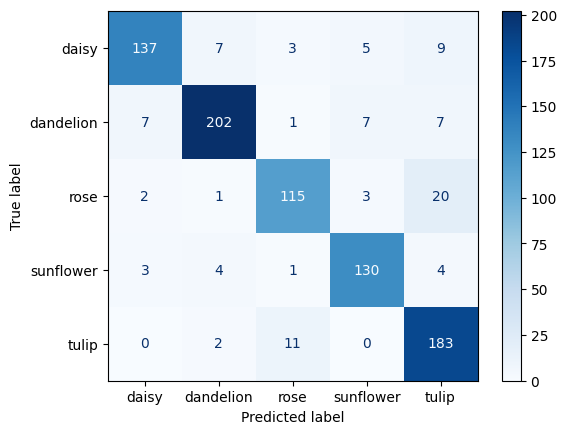

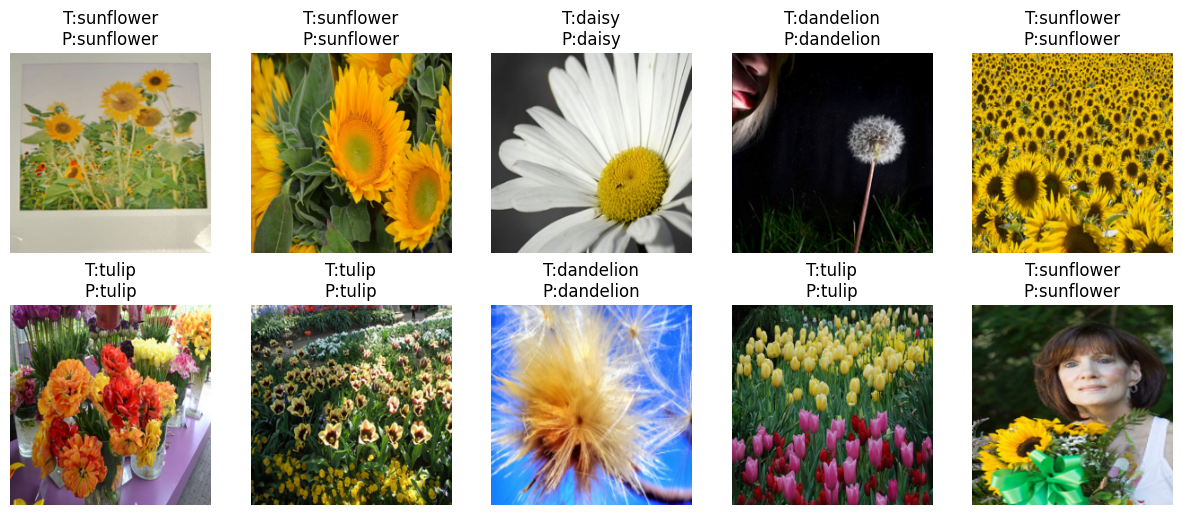

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import zipfile
import os

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SEED = 20240307
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


zip_path = "/content/flowers.zip"
extract_path = "/content"

if not os.path.exists("/content/flowers"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

data_dir = "/content/flowers"

print("Dataset folders:", os.listdir(data_dir))


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Classes:", class_names)
print("Train:", len(train_ds), "Val:", len(val_ds))

def get_model():
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(512, 5)
    return model.to(device)


def train_model(model, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc.append(correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc.append(correct / total)
        print(f"Epoch {epoch+1}: Train={train_acc[-1]:.3f}, Val={val_acc[-1]:.3f}")

    return train_acc, val_acc


model_v1 = get_model()
optimizer_v1 = optim.Adam(model_v1.fc.parameters(), lr=0.0001)
train_acc_v1, val_acc_v1 = train_model(model_v1, optimizer_v1)

model_v2 = get_model()
optimizer_v2 = optim.SGD(model_v2.fc.parameters(), lr=0.001, momentum=0.9)
train_acc_v2, val_acc_v2 = train_model(model_v2, optimizer_v2)


plt.figure()
plt.plot(val_acc_v1, label="Version 1 (Adam)")
plt.plot(val_acc_v2, label="Version 2 (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

results = pd.DataFrame({
    "Version": ["Version 1 (Adam)", "Version 2 (SGD)"],
    "Best Val Accuracy": [max(val_acc_v1), max(val_acc_v2)]
})
print(results)

best_model = model_v2 if max(val_acc_v2) > max(val_acc_v1) else model_v1

y_true, y_pred = [], []
best_model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(15,6))

for i, idx in enumerate(samples):
    image, label = val_ds[idx]
    with torch.no_grad():
        pred = best_model(image.unsqueeze(0).to(device)).argmax(1).item()

    img = image.permute(1,2,0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"T:{class_names[label]}\nP:{class_names[pred]}")
    plt.axis("off")

plt.show()

